# 随机森林

## 1.  集成算法

目标：集成算法考虑了多个评估器的建模结果，汇总之后得到综合结果，以此获取比单个评估器更好的回归或者分类表现

## 2.  随机森林

* **参数** ： n_estimator,限制基学习器的数量

**一般取值越大，模型表现越好。** 但任何模型都有决策边界后，在达到一定大小后，随着n_estimator增加，随机森林的精确性开始波动，并且随着n_estimator越大，计算量和内存越大，训练时间越长。对于这个参数，我们希望在训练难度和模型效果之间取得平衡。一般来说在0-200之间取一个数，会比较好。

**1.  导入包和数据集**

In [ ]:
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.model_selection import train_test_split

In [3]:
wine = load_wine()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3)

**2. 实例化模型**

In [9]:
clf = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

clf = clf.fit(x_train, y_train)
rfc = rfc.fit(x_train, y_train)

score_c = clf.score(x_test, y_test)
score_f = rfc.score(x_test, y_test)

print('single tree:{}, random forest:{}'.format(score_c, score_f))

single tree:0.9259259259259259, random forest:0.9814814814814815


这是在一个数据集上的结果表现，可能不可信。因此，采用交叉验方法来检验。

**交叉验证下算法的对比**

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
import matplotlib.pyplot as plt

* 一次交叉验证

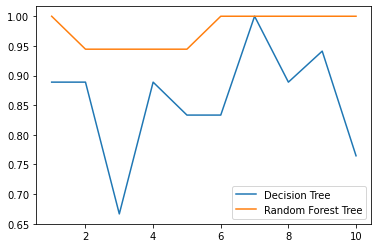

In [13]:
clf = DecisionTreeClassifier()
clf_s = cross_val_score(clf, wine.data, wine.target, cv=10)

rfc = RandomForestClassifier(n_estimators = 25)
rfc_s = cross_val_score(rfc, wine.data, wine.target, cv=10)

plt.plot(range(1,11),  clf_s, label='Decision Tree')
plt.plot(range(1,11),  rfc_s, label='Random Forest Tree')
plt.legend()
plt.show()

In [16]:
# ========================= 另一种写法 =============================#
# models = [DecisionTreeClassifier(), RandomForestClassifier(n_estimators = 25)]
# labels = ['Decision Tree', 'Random Forest Tree']

# for i in range(2):
#     score = cross_val_score(models[i], wine.data, wine.target, cv=10)
#     plt.plot(range(1, 11), score, label = labels[i])
#     plt.legend()

* 十次交叉验证

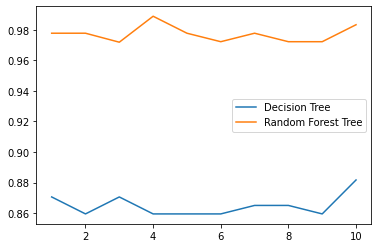

In [18]:
clf_l = []
rfc_l = []

for i in range(10):
    clf = DecisionTreeClassifier()
    clf_s = cross_val_score(clf, wine.data, wine.target, cv=10).mean()
    clf_l.append(clf_s)

    rfc = RandomForestClassifier(n_estimators = 25)
    rfc_s = cross_val_score(rfc, wine.data, wine.target, cv=10).mean()
    rfc_l.append(rfc_s)

plt.plot(range(1,11),  clf_l, label='Decision Tree')
plt.plot(range(1,11),  rfc_l, label='Random Forest Tree')
plt.legend()
plt.show()

可以看出，随机森林的性能比决策树整体来讲，要好太多。同图中可以看出，随机森林和决策树的转折有些相似，一般来说，决策树效果越好，随机森林的效果应该也会越好。如果图中违背了这样的规律，可能是因为训练集、测试集的划分不太合理。

**3. n_estimator的学习曲线**

0.9888888888888889 34


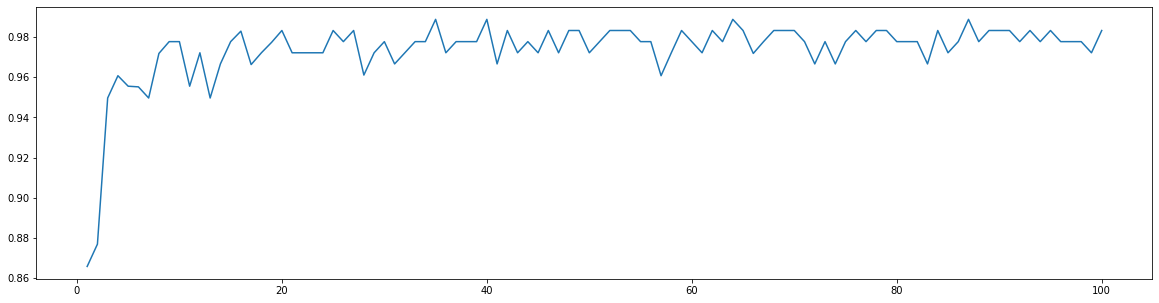

In [20]:
superpa = []
for i in range(100):
    rfc = RandomForestClassifier(n_estimators = i+1, n_jobs=-1)
    rfc_s = cross_val_score(rfc, wine.data, wine.target, cv=10).mean()
    superpa.append(rfc_s)
print(max(superpa), superpa.index(max(superpa)))

plt.figure(figsize=(20,5))
plt.plot(range(1, 101), superpa)
plt.show()

可以看出，n_estimator在20左右到达顶峰，之后随着n_estimator的增加，随机森林的准确性会逐渐波动。

**思考** ：为什么随机森林优于决策树

因为随机森林是一种投票的机制，只要当半数以上的树判断出错时，最终结果才会出错。按照这样的理论计算后，以25颗树为例，假设每个树出错的概率为0.2

In [22]:
import numpy as np
from scipy.special import comb  # 求组合

In [24]:
np.array([comb(25, i)*(0.2**i)*((1-0.2)**(25-i)) for i in range(13,26)]).sum()

0.00036904803455582827

可以看到，判断错误的概率非常小，这让随机森林的表现比决策树好很多。（有一个潜在的前提：每个树的犯错概率差不多，即不能太差）

同时我们想到另一个问题，装袋法(bagging)是对基分类器的结果进行表决或者求平均，那么就要求各个基分类器应该不一样，否则无论n_estimator取值大小，结果都不变。那么采用了一样的分类树，一样的参数，为什么随机森林中的树会有不同的分类结果呢？

我们自然想到了sklearn.DecisionTreeClassifier自带随机性，所以随机森林中的树天生是不一样的，决策树每次都会从重要的特征中随机选择一个特征进行分支，因此每次生成的特征树都不一样，这个功能由random_state控制。

随机森林中也有random_state，只不过它控制的是随机森林的模式，而不是一棵树。

**查看生成的树**

In [27]:
rfc = RandomForestClassifier(n_estimators=25, random_state=2)
rfc = rfc.fit(x_train, y_train)

* **estimators属性**，查看森林中树的状况

In [28]:
rfc.estimators_
rfc.estimators_[0].random_state

[DecisionTreeClassifier(max_features='auto', random_state=1872583848),
 DecisionTreeClassifier(max_features='auto', random_state=794921487),
 DecisionTreeClassifier(max_features='auto', random_state=111352301),
 DecisionTreeClassifier(max_features='auto', random_state=1853453896),
 DecisionTreeClassifier(max_features='auto', random_state=213298710),
 DecisionTreeClassifier(max_features='auto', random_state=1922988331),
 DecisionTreeClassifier(max_features='auto', random_state=1869695442),
 DecisionTreeClassifier(max_features='auto', random_state=2081981515),
 DecisionTreeClassifier(max_features='auto', random_state=1805465960),
 DecisionTreeClassifier(max_features='auto', random_state=1376693511),
 DecisionTreeClassifier(max_features='auto', random_state=1418777250),
 DecisionTreeClassifier(max_features='auto', random_state=663257521),
 DecisionTreeClassifier(max_features='auto', random_state=878959199),
 DecisionTreeClassifier(max_features='auto', random_state=854108747),
 DecisionTre

In [29]:
for i in range(len(rfc.estimators_)):
    print(rfc.estimators_[i].random_state)

1872583848
794921487
111352301
1853453896
213298710
1922988331
1869695442
2081981515
1805465960
1376693511
1418777250
663257521
878959199
854108747
512264917
515183663
1287007039
2083814687
1146014426
570104212
520265852
1366773364
125164325
786090663
578016451


In [30]:
# 尽量避免循环，但这里因为rfc.estimators_中的每颗树类型都是sklearn中的类型，如果采用别的方式把每颗树放到一个容器中，会失去树的类型，无法调用相关属性

用袋装法bagging进行学习时，基学习器应该是互相独立、不相同的，这种不同在sklearn中由随机挑选特征进行分支来保证，但这种做法局限性比较强。

尤其是在我们需要几百上千颗树时，数据不一定能够提供那么多特征来构造那么多树木。因此除了random_state，我们还需要其他的随机性。

## **3.  增加随机性**

+ **boot_strap & oob_socre**

要让基学习器不同，最简单的方式就是每个基学习器采用不同的数据集进行训练。袋装法正是通过有放回的抽样来形成不同的训练数据，bootstrap是控制抽样的参数

在一个含有n个样本的数据集中，我们进行有放回的抽样，形成一个规模为n的自助集。由于是随机采样，每个自助集都和原始数据集不同和其他自助集也不同，这样就形成了多个自助集来训练模型，生成不同的基分类器。

**bootstrap参数默认设置为True**, 通常不会修改

然而，自助集也有它的问题。由于进行有放回的抽样，一些样本可能在自助集里出现多次，而其他一些可能完全被忽略。**一般来说，自助集中会包含大约63%的原始数据**，因为每个样本被抽到自助集的概率为

$$1-(1-\frac{1}{n})^n$$

当n足够大时，这个概率收敛于1-1/e约等于0.632, 因此会有约0.37的数据被浪费，没有参与建模，这些数据被称为**袋外数据(out-of-bag， oob)**。除了最开始就分好的训练集和测试集外，这些数据也可以被用来作为算法的测试集。**也就是说，在使用随机森林时，可以不划分训练集和测试集，而使用袋外数据作为测试集验证模型**。当然，这也不是绝对的，当n和n_estimators都比较小，可能没有数据落在袋外，自然也就无法使用袋外数据测试模型了。

如果希望用袋外数据来测试，那么在实例化时，就需要将 **oob_score参数** 设置为True, 训练完毕后，可以采用随机森林的另一个重要属性 **oob_score_** 来查看结果

In [37]:
# 无需划分训练集和测试集
rfc = RandomForestClassifier(n_estimators=25, oob_score=True)
rfc = rfc.fit(wine.data, wine.target)

In [38]:
# 重要属性
rfc.oob_score_

0.9719101123595506

## **4. 重要属性和接口**

+ **feature_importances_**

In [39]:
rfc = RandomForestClassifier(n_estimators=25, random_state=2)
rfc = rfc.fit(x_train, y_train)

In [47]:
# rfc.feature_importances_
[*zip(wine.feature_names, rfc.feature_importances_)]

[('alcohol', 0.10753708972755596),
 ('malic_acid', 0.03329949680584265),
 ('ash', 0.017576428836028897),
 ('alcalinity_of_ash', 0.034114880227770414),
 ('magnesium', 0.01632270338637155),
 ('total_phenols', 0.06814214966515907),
 ('flavanoids', 0.2084394666721964),
 ('nonflavanoid_phenols', 0.00721033274914976),
 ('proanthocyanins', 0.027900738171613027),
 ('color_intensity', 0.12500740578803013),
 ('hue', 0.08525958504660974),
 ('od280/od315_of_diluted_wines', 0.1268889077325224),
 ('proline', 0.14230081519115004)]

In [41]:
rfc.apply(x_train)

array([[ 9,  3, 13, ..., 15,  4,  7],
       [15, 16, 16, ..., 16, 19, 18],
       [15, 10, 16, ..., 16, 19, 18],
       ...,
       [15, 16, 16, ..., 16, 19, 18],
       [15, 16, 16, ..., 16, 21, 18],
       [ 4,  3,  6, ..., 12, 12, 13]], dtype=int64)

In [42]:
rfc.predict(x_train)

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2,
       0, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1,
       0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0,
       1, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1,
       1, 2, 0, 2, 2, 1, 2, 0, 0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 2, 1, 2, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 2])

In [43]:
rfc.predict_proba(x_train)

array([[0.  , 0.92, 0.08],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.96, 0.04, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.96, 0.04, 0.  ],
       [0.96, 0.04, 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.04, 0.08, 0.88],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.96, 0.04, 0.  ],
       [0.  , 0.04, 0.96],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.08, 0.92, 0.  ],
       [0.  , 0.96, 0.04],
       [0.08, 0.88, 0.04],
       [0.96, 0.04, 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.96, 0.04],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.12, 0.88, 0.  ],
       [0.96, 0.04, 0.  ],
       [0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
 

## **5. 袋装法的另一个要求**

基学习器的性能至少要超过随机分类器，即基学习器的性能至少要超过50%。之前已经展示过随机森林的准确率公式，基于此，可以画出基分类器的误差率和随机森林误差率的图像。

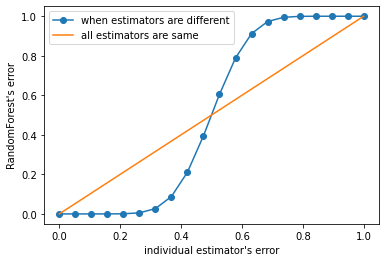

In [54]:
# 当基学习器的epsilon改变时，算法性能的改变
import numpy as np
x = np.linspace(0,1,20)

y = []
for epsilon in np.linspace(0,1,20):
    E = np.array([comb(25, i)*(epsilon**i)*((1-epsilon)**(25-i)) for i in range(13,26)]).sum()
    y.append(E)

plt.plot(x, y, 'o-', label='when estimators are different')
plt.plot(x, x, label='all estimators are same')
plt.xlabel("individual estimator's error")
plt.ylabel("RandomForest's error")
plt.legend()
plt.show()

In [ ]:
可以看出，当基分类器的误差率小于0.5，即准确率大于0.5时，集成学习的效果较好；相反基分类器误差率大于0.5，集成的算法会失效。所以使用集成算法前，必须检查基分类器的准确率在0.5以上。